In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from matplotlib.animation import FuncAnimation, PillowWriter
from mpl_toolkits import mplot3d
from matplotlib import rcParams
import copy
import math
import sys
sys.setrecursionlimit(2000)

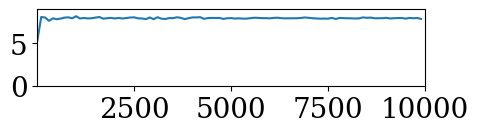

7.874037965157628


In [2]:
############################################################
### Determine mean distance needed to cross a square box ###
############################################################
d = 5 # <-- edge distance

nPoints_min =  2
nPoints_max = 10000
nPoints_delta = 100
list_nPoints = []
list_val = []

# Very computationally inefficient😊:
#   Should reuse previous smaller 
#   approximations so it would 
#   be O(N) and not ~O(N^2)
for nPoints in range(nPoints_min, nPoints_max, nPoints_delta):
  total = 0
  for nPoint in range(1,nPoints):
    p_1 = [np.random.uniform(0,d),0]
    p_2 = []
    temp = np.random.uniform(0,d*3)
    if temp <= d:
      p_2 = [0,temp]
    elif temp > d and temp <= d*2:
      p_2 = [temp,d]
    else:
      p_2 = [d,temp]
  
    total = total + ((p_1[0]-p_2[0])**2 + (p_1[1]-p_2[1])**2)**(1/2)
  list_nPoints.append(nPoints)
  list_val.append(total/nPoints)

font = {'family' : 'serif', 'size' : 20 }
mpl.rc('font', **font)
mpl.rcParams['mathtext.fontset'] = 'cm' # Set the math font to Computer Modern
mpl.rcParams['legend.fontsize'] = 1
plt.figure(figsize=(5,1))
plt.plot(list_nPoints, list_val)
plt.ylim(0, 9)
# plt.xlim(nPoints_max-nPoints_delta*10,nPoints_max)
plt.xlim(nPoints_min,nPoints_max)
# plt.savefig('meanDistance.pdf',bbox_inches='tight')
plt.show()

meanDist = list_val[-1]
print(meanDist)

In [4]:
# 2-dimensional lens and optical system class
#    It is assumed that the ray travels in the +x-direction, 
#    that is theta < pi/2 where theta=\atan(gamma_y/gamma_x)

#########################################################################################################################
############################################## Function: quadraticEquation ##############################################
#########################################################################################################################
def quadraticEquation(sign, c_1, c_2, c_3):
    num = c_2**2 - 4*c_1*c_3
    if num < 0:
        print('WARNING: num cannot be < 0')
        return 'error'
    return ( -c_2 + sign*num**(1/2) ) / (2*c_1)

############################################################################################################
############################################## Class: surface ##############################################
############################################################################################################
class surface:
    def __init__(self,surface):
        self.r_x = surface.r_x
        self.r_y = surface.r_y
        self.x   = surface.x
        
    def __init__(self,r_x,r_y,x):
        if r_x == 0 or r_y == 0:
            raise ValueError("Radius cannot be 0")
        self.r_x = r_x
        self.r_y = r_y
        self.x   = x
    
    def get_points(self,nPoints,safty=1e-5):
        sign = 0
        if self.r_x < 0:
            sign = -1
        else:
            sign = +1
        lim = [self.x+sign*safty,self.x+self.r_x-sign*safty]
            
        points = []
        for x in np.linspace(lim[0],lim[1],nPoints):
            y = (self.r_y**2 + self.r_y**2/self.r_x**2*(-x**2+2*x*self.x-self.x**2))**(1/2)
            points.append((x,y))
        for x in np.linspace(lim[1],lim[0],nPoints):
            y = (self.r_y**2 + self.r_y**2/self.r_x**2*(-x**2+2*x*self.x-self.x**2))**(1/2)
            points.append((x,-y))
            
        return points
        
class lens:
    def __init__(self,lens):
        self.surface_1 = lens.surface_1
        self.surface_2 = lens.surface_2
        self.refInd    = lens.refInd
        self.__sortSurfaces()
        
    def __init__(self,surface_1,surface_2,refInd):
        self.surface_1 = surface_1
        self.surface_2 = surface_2
        self.refInd    = refInd
        self.__sortSurfaces()
        
    def __sortSurfaces(self):
        if self.surface_1.x + self.surface_1.r_x > self.surface_2.x + self.surface_2.r_x:
            self.surface_1, self.surface_2 = self.surface_2, self.surface_1
    
    def get_points(self,nPoints):
        return self.surface_1.get_points(nPoints), self.surface_2.get_points(nPoints)
            
##################################################################################################################
############################################## Class: opticalSystem ##############################################
##################################################################################################################
class opticalSystem:
    def __init__(self,lenses,finalSurface,refInd):
        self.lenses       = lenses
        self.finalSurface = finalSurface
        self.__sort_lenses()
        self.__check_lensOverlap()
        self.__check_finalSurface()
        self.surfaces = []
        for lens in lenses:
            self.surfaces.append(lens.surface_1)
            self.surfaces.append(lens.surface_2)
        self.surfaces.append(self.finalSurface)
        self.__check_surfaces_length()
        
        self.refIndices = [refInd]
        for lens in lenses:
            self.refIndices.append(lens.refInd)
            self.refIndices.append(refInd)
    
    def add_lens(self,lens):
        self.lenses.append(lens)
        self.__sortLenses()
        self.__check_lensOverlap()
        self.__check_finalSurface()
        self.__check_surfaces_length()
        self.__update_surfaces_order(lens)
    
    def __sort_lenses(self):
        self.lenses.sort(key=lambda lens: lens.surface_1.x + lens.surface_1.r_x)
        
    def __check_lensOverlap(self):
        for i in range(len(self.lenses) - 1):
            lens_1 = self.lenses[i]
            lens_2 = self.lenses[i + 1]
            surface_1 = lens_1.surface_2
            surface_2 = lens_2.surface_1
            if surface_1.x + surface_1.r_x > surface_2.x + surface_2.r_x:
                raise ValueError("Lens overlap detected")
        return True
    
    def __check_finalSurface(self):
        lastLensSurface = self.lenses[-1].surface_2.r_x + self.lenses[-1].surface_2.x
        if lastLensSurface > self.finalSurface.r_x + self.finalSurface.x:
            raise ValueError("Final surface does not have greatest radius+x")
        return True
    
    def __update_surfaces_order(self,lens):
        # O(N) (linear) implementation
        # could use bisection to make faster for large N
        for surface in self.surfaces:
            if surface.r_x + surface.x > lens.surface_1.r_x + lens.surface_2.x:
                self.surfaces.append(lens_surface_1)
                self.surfaces.append(lens_surface_2)
                break
                
    def __check_surfaces_length(self):
        if len(self.surfaces) == 0:
            raise ValueError("Surfaces cannot be empty")
            
    def get_points(self,nPoints):
        points = []
        for surface in self.surfaces:
            points.append(surface.get_points(nPoints))
            
        return points

###############################################################################################################
############################################## Class: opticalRay ##############################################
###############################################################################################################
class opticalRay:
    def __init__(self,opticalRay):
        self.x     = opticalRay.x
        self.y     = opticalRay.y
        self.theta = opticalRay.theta
        self.__checkTheta()
        
    def __init__(self,x,y,theta):
        self.x     = x
        self.y     = y
        self.theta = theta
        self.__checkTheta()
    
    def update_theta(self,theta):
        self.theta = theta
        return self.__checkTheta()
    
    def __checkTheta(self):
        if self.theta <= -math.pi/2 or self.theta >= math.pi/2:
            raise ValueError("Theta out of bounds")
            
        while self.theta < 0:
            self.theta = self.theta + 2*math.pi
            
        return True
    
##################################################################################################################
############################################## Class: rayPropagator ##############################################
##################################################################################################################
class rayPropagator:
    def __init__(self,opticalSystem,opticalRay):
        self.opticalSystem = opticalSystem
        self.opticalRay    = opticalRay
        if self.opticalRay.x > self.opticalSystem.surfaces[0].r_x + self.opticalSystem.surfaces[0].x:
            raise ValueError("x-position of optical ray is not less than all lenses' x-positions")
        
    def propagateRay(self,nSurfacesPropagate=-1):
        opticalRay_temp = copy.deepcopy(self.opticalRay)
        steps = [copy.deepcopy(opticalRay_temp)]
            
        if nSurfacesPropagate > len(self.opticalSystem.surfaces): 
            nSurfacesPropagate = -1
            
        self.__translateRay(self.opticalSystem.surfaces[0],opticalRay_temp)
        steps.append(copy.deepcopy(opticalRay_temp))
        for nSurface in range(0,len(self.opticalSystem.surfaces)-1):
            if nSurfacesPropagate>0 and nSurface+1 > nSurfacesPropagate:
                break
                
            if opticalRay_temp.theta < 0:
                steps.append(copy.deepcopy(opticalRay_temp))
            else:
                self.__refractRay(self.opticalSystem.surfaces[nSurface],opticalRay_temp,self.opticalSystem.refIndices[nSurface],self.opticalSystem.refIndices[nSurface+1])
                self.__translateRay(self.opticalSystem.surfaces[nSurface+1],opticalRay_temp)
                steps.append(copy.deepcopy(opticalRay_temp))
        
        return steps
    
    def __translateRay(self,surface,opticalRay_temp):
        if surface.r_x > 0: sign = +1
        if surface.r_x < 0: sign = -1
        
        m = math.tan(opticalRay_temp.theta)
        c_1 = 1/surface.r_x**2 + m**2/surface.r_y**2
        c_2 = -2*surface.x/surface.r_x**2 + m/surface.r_y**2 * (-2*m*opticalRay_temp.x + 2*opticalRay_temp.y)
        c_3 = surface.x**2/surface.r_x**2 + ((m*opticalRay_temp.x - opticalRay_temp.y)/surface.r_y)**2 - 1
        
        x_original = opticalRay_temp.x
        num = quadraticEquation(sign,c_1,c_2,c_3)
        if num == 'error':
            print('WARNING: ray translated to invalid point')
            opticalRay_temp.theta = -99999
        else:
            opticalRay_temp.x = num
            opticalRay_temp.y = m * (opticalRay_temp.x - x_original) + opticalRay_temp.y
        
        # print('x',opticalRay_temp.x)
        # print('y',opticalRay_temp.y)
        
        return opticalRay_temp
    
    def __refractRay(self,surface,opticalRay_temp,refInd_i,refInd_f):
        num = surface.r_y**2/surface.r_x**2*(-opticalRay_temp.x**2+2*surface.x*opticalRay_temp.x-surface.x**2)+surface.r_y**2
        # print('x',opticalRay_temp.x)
        if num <  0: print('WARNING: num<0:',num); num = 0
        if num == 0: num = 1e-25
        dydx = surface.r_y**2/surface.r_x**2*(surface.x-opticalRay_temp.x)*num**(-1/2)
        theta_0 = math.atan(1/dydx)
        num2 = refInd_i/refInd_f*math.sin(theta_0-opticalRay_temp.theta)
        if abs(num2)>1: 
            print('WARNING: total internal reflection, |num2|>1:',num2)
            opticalRay_temp.theta = -99999
        else:
            opticalRay_temp.update_theta(math.asin(num2))
        
        return opticalRay_temp
    

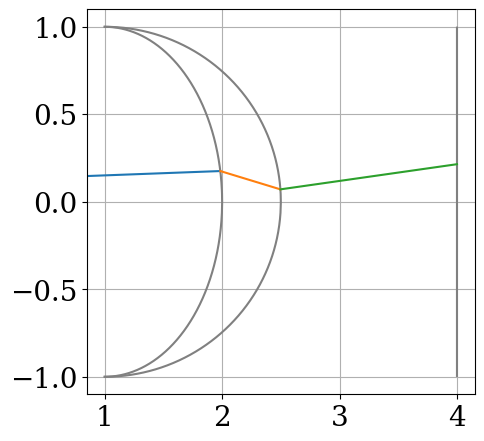

In [5]:
surface_1 = surface(1.5,1,1)        # r_x, r_y, x
surface_2 = surface(1,1,1)          # r_x, r_y, x
surface_f = surface(0.0001,1,4)     # r_x, r_y, x
L = lens(surface_1,surface_2,1)     # surface_1, surface_2, refInd
OS = opticalSystem([L],surface_f,1) # [lenses], finalSurface, refInd

font = {'family' : 'serif', 'size' : 20 }
mpl.rc('font', **font)
mpl.rcParams['mathtext.fontset'] = 'cm' # Set the math font to Computer Modern
mpl.rcParams['legend.fontsize'] = 1

fig, ax = plt.subplots(figsize=(5,5))
ax.grid()

points_surfaces = OS.get_points(1000)
surface_1 = ax.plot([x for x,y in points_surfaces[0 ]], [y for x,y in points_surfaces[0 ]], color='gray')[0]
surface_2 = ax.plot([x for x,y in points_surfaces[1 ]], [y for x,y in points_surfaces[1 ]], color='gray')[0]
surface_f = ax.plot([x for x,y in points_surfaces[-1]], [y for x,y in points_surfaces[-1]], color='gray')[0]
ray_i = ax.plot([],[])[0]
ray_l = ax.plot([],[])[0]
ray_f = ax.plot([],[])[0]
def updateFrame(nFrame):
    theta_min = -math.pi/100 # <-- PARAMETER
    theta_max =  math.pi/100 # <-- PARAMETER
    theta = theta_min + ( theta_max - theta_min ) / nFrames * nFrame
    OR              = opticalRay(-5,0,theta) # x, y, theta
    RP              = rayPropagator(OS,OR)   # opticalSystem, opticalRay
    points_ray      = RP.propagateRay()
    points_ray_formatted = []
    for nPoint in range(len(points_ray)-1):
        points_ray_formatted.append(([points_ray[nPoint].x,points_ray[nPoint+1].x],[points_ray[nPoint].y,points_ray[nPoint+1].y]))
    
    ray_i.set_data(points_ray_formatted[0][0], points_ray_formatted[0][1])
    ray_l.set_data(points_ray_formatted[1][0], points_ray_formatted[1][1])
    ray_f.set_data(points_ray_formatted[2][0], points_ray_formatted[2][1])
    return surface_1, surface_2, surface_f, ray_i, ray_l, ray_f

nFrames = 10
animation = FuncAnimation(fig, updateFrame, frames=nFrames, interval=100, blit=True)
animation.save('test.gif', writer='pillow')
plt.show()

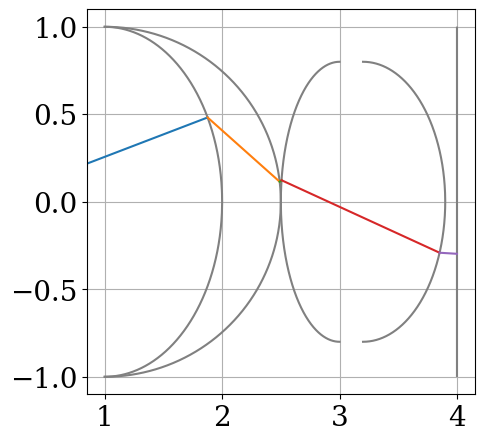

In [6]:
surface_1 = surface(1.5,1,1)               # r_x, r_y, x
surface_2 = surface(1,1,1)                 # r_x, r_y, x
surface_3 = surface(-.5,0.8,3)             # r_x, r_y, x
surface_4 = surface( .7,0.8,3.2)           # r_x, r_y, x
surface_f = surface(0.0001,1,4)            # r_x, r_y, x
L_1 = lens(surface_1,surface_2,2)          # surface_1, surface_2, refInd
L_2 = lens(surface_3,surface_4,2)          # surface_1, surface_2, refInd
OS  = opticalSystem([L_1,L_2],surface_f,1.5) # [lenses], finalSurface, refInd

font = {'family' : 'serif', 'size' : 20 }
mpl.rc('font', **font)
mpl.rcParams['mathtext.fontset'] = 'cm' # Set the math font to Computer Modern
mpl.rcParams['legend.fontsize'] = 1

fig, ax = plt.subplots(figsize=(5,5))
ax.grid()

points_surfaces = OS.get_points(1000)
surface_1 = ax.plot([x for x,y in points_surfaces[0 ]], [y for x,y in points_surfaces[0 ]], color='gray')[0]
surface_2 = ax.plot([x for x,y in points_surfaces[1 ]], [y for x,y in points_surfaces[1 ]], color='gray')[0]
surface_3 = ax.plot([x for x,y in points_surfaces[2 ]], [y for x,y in points_surfaces[2 ]], color='gray')[0]
surface_4 = ax.plot([x for x,y in points_surfaces[3 ]], [y for x,y in points_surfaces[3 ]], color='gray')[0]
surface_f = ax.plot([x for x,y in points_surfaces[-1]], [y for x,y in points_surfaces[-1]], color='gray')[0]
ray_i1 = ax.plot([],[])[0]
ray_12 = ax.plot([],[])[0]
ray_23 = ax.plot([],[])[0]
ray_34 = ax.plot([],[])[0]
ray_4f = ax.plot([],[])[0]
def updateFrame(nFrame):
    theta_min = -math.pi/10 # <-- PARAMETER
    theta_max =  math.pi/10 # <-- PARAMETER
    theta = theta_min + ( theta_max - theta_min ) / nFrames * nFrame
    OR              = opticalRay(-0,0,theta) # x, y, theta
    RP              = rayPropagator(OS,OR)   # opticalSystem, opticalRay
    points_ray      = RP.propagateRay()
    points_ray_formatted = []
    for nPoint in range(len(points_ray)-1):
        points_ray_formatted.append(([points_ray[nPoint].x,points_ray[nPoint+1].x],[points_ray[nPoint].y,points_ray[nPoint+1].y]))
    
    ray_i1.set_data(points_ray_formatted[0][0], points_ray_formatted[0][1])
    ray_12.set_data(points_ray_formatted[1][0], points_ray_formatted[1][1])
    ray_23.set_data(points_ray_formatted[2][0], points_ray_formatted[2][1])
    ray_34.set_data(points_ray_formatted[3][0], points_ray_formatted[3][1])
    ray_4f.set_data(points_ray_formatted[4][0], points_ray_formatted[4][1])
    return surface_1, surface_2, surface_3, surface_4, surface_f, ray_i1, ray_12, ray_23, ray_34, ray_4f

nFrames = 10
animation = FuncAnimation(fig, updateFrame, frames=nFrames, interval=100, blit=True)
animation.save('test.gif', writer='pillow')
plt.show()